In [13]:
from urban_watch.ml_logic.data import load_data
from urban_watch.ml_logic.package import preprocess_image
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

In [3]:
X, meta = load_data()
X_processed = []
for i, img in enumerate(X):
    X_processed.append(preprocess_image(img))
X_processed = np.array(X_processed)

In [4]:
X_processed.shape

(10, 300, 300, 13)

In [5]:
X_processed

array([[[[ 7.28944278e-01,  1.11544327e+00,  8.72419174e-01, ...,
          -1.58050604e+00,  9.76907822e-01,  1.71098639e+00],
         [ 7.28944278e-01,  1.18216340e+00,  7.47128873e-01, ...,
          -1.22982430e+00,  5.90390190e-01,  1.60776268e+00],
         [ 7.28944278e-01,  1.86493774e-01, -3.24549550e-02, ...,
          -2.25973143e-01,  1.95055230e-02,  4.93673921e-01],
         ...,
         [ 5.31724349e-01, -2.67716240e-01,  2.78698765e-02, ...,
           8.45167141e-01,  2.47257515e-01, -6.72501264e-01],
         [ 5.31724349e-01,  5.48322220e-01,  6.72882880e-01, ...,
          -4.04440837e-01,  5.15472241e-01, -3.53238361e-03],
         [ 5.31724349e-01,  1.14110463e+00,  1.33645708e+00, ...,
          -7.85510533e-01,  9.67771883e-01,  1.41635759e-01]],

        [[ 7.28944278e-01,  1.22835423e+00,  8.44576852e-01, ...,
          -1.70839653e+00,  8.96394416e-01,  1.67466953e+00],
         [ 7.28944278e-01,  1.19756011e+00,  5.61513590e-01, ...,
          -1.39027556e

In [6]:
n_tiles, h, w, n_bands = X_processed.shape
X_flatten = X_processed.reshape(-1, n_bands)

In [8]:
np.isnan(X_flatten).sum()

np.int64(3267498)

In [9]:
np.isnan(X_flatten).any()

np.True_

In [10]:
mask_valid= ~np.isnan(X_flatten).any(axis=-1)
X_clean = X_flatten[mask_valid]

In [11]:
print(X_clean.shape)

(648654, 13)


In [19]:
pca = PCA(n_components=5, random_state=1)
X_pca = pca.fit_transform(X_clean)
print(pca.explained_variance_ratio_.sum())

0.9592907753296852


le sous echantillonnage pour test K

In [20]:
N_SAMPLE = 50000

if len(X_pca) > N_SAMPLE:
    idx = np.random.choice(len(X_pca), size=N_SAMPLE, replace=False)
    X_sample = X_pca[idx]
else:
    X_sample = X_pca

print(X_sample.shape)

(50000, 5)


Test de k 

In [26]:
k_values = range(2,11)
result = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=10)
    y_pred = kmeans.fit_predict(X_sample)
    silhouette = silhouette_score(X_sample, y_pred)
    inertia = kmeans.inertia_
    result[k] ={
        "silhouette": silhouette,
        "inertia" : kmeans.inertia_
    }
    print (f"{silhouette}|Inertia = {inertia}")

0.28171880994116905|Inertia = 434290.1821908478
0.2561012856075891|Inertia = 343580.13325398054
0.2688449599710799|Inertia = 276726.5510409676
0.2512502281127519|Inertia = 246275.20789752246
0.2436204518969314|Inertia = 218063.0509300894
0.22589331714365576|Inertia = 200834.65091079453
0.2210279206582693|Inertia = 188237.27478671432
0.21902134723611547|Inertia = 177345.9370829311
0.21108954554216042|Inertia = 167512.9364398188


Clustering failbe/bruit fort mais attendu car forte correlation spatiale entre 13 bandes
inertia 167512:
si enertia baisse bcp entre k 3 5 -> structure forte
si inertia baisse peu pour k 7 -> optimum atteint

In [28]:
best_k = max(result.keys(), key=lambda k: result[k]["silhouette"])
print("meilleur k:", best_k)
print("silhouette", result[best_k]["silhouette"])

meilleur k: 2
silhouette 0.28171880994116905


In [ ]:
final_kmeans = KMeans(n_clusters=best_k, random_state=1, n_init=10)
final_labels= final_kmeans.fit_predict(X_pca)
#entrainement final
sil_vals = [result[k]["silhouette"] for k in k_values]
inertia = [result[k]["inertia"] for k in k_values]

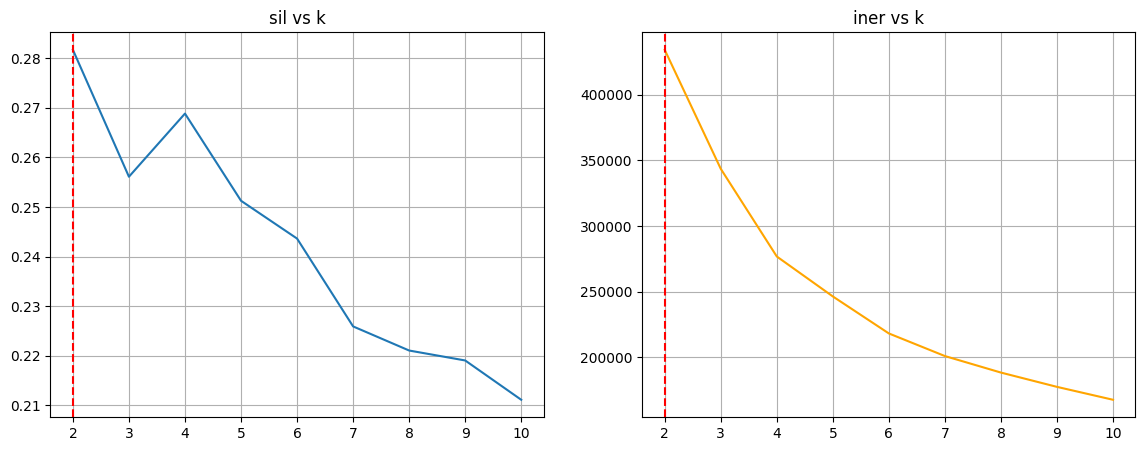

In [33]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(k_values, sil_vals)
plt.title("sil vs k")
plt.grid(True)
plt.axvline(best_k, color="red", linestyle='--')

plt.subplot(1,2,2)
plt.plot(k_values, inertia, color="orange")
plt.title("iner vs k")
plt.grid(True)
plt.axvline(best_k, color="red", linestyle= "--")
plt.show()

quand k>2 KMEANs invente des classes et donc le scores baisse dans le sil score donc 0.28 est notre meilleur valeur

dans inertia le coude elbow est clairement entre 3 et 4 donc k=4 les gains deviennent faibles

CONCLUSION : 
sil -> k=2
iner -> k=3 ou 4